In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [56]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [57]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [61]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_date =  session.query(func.max(measurement.date)).all()[0][0]
# Calculate the date 1 year ago from the last data point in the database
last_year =  dt.datetime.strptime(last_date, '%Y-%m-%d') - dt.timedelta(days=365)
# Perform a query to retrieve the data and precipitation scores; Sort the dataframe by date
retrieve_data = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date >= last_year).\
    order_by(measurement.date).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
last_12moths_precipitation_df = pd.DataFrame(retrieve_data, columns = ["date", "precipitation"])
last_12moths_precipitation_df.set_index('date', inplace=True)
last_12moths_precipitation_df.dropna()
last_12moths_precipitation_df.head()

,precipitation
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,NaN
2016-08-24,1.22


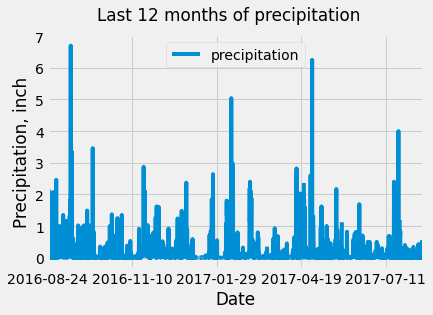

In [112]:
# Use Pandas Plotting with Matplotlib to plot the data
last_12moths_precipitation_df.plot()
plt.suptitle('Last 12 months of precipitation')
plt.xlabel('Date')
plt.ylabel('Precipitation, inch')
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
plt.savefig(f"{title}.png")
plt.show()

In [66]:
# Use Pandas to calcualte the summary statistics for the precipitation data
last_12moths_precipitation_df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [68]:
# Design a query to show how many stations are available in this dataset?
total_station = session.query(measurement.station).group_by(measurement.station).count()
total_station

9

In [69]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(measurement.station, func.count(measurement.station)).\
        group_by(measurement.station).\
        order_by(func.count(measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [78]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
extremum = session.query(measurement.station, func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).\
           filter(measurement.station == 'USC00519281')
extremum_df=pd.DataFrame(data=extremum, columns=['station', 'min', 'max', 'avg'])
extremum_df

,station,min,max,avg
0,USC00519281,54.0,85.0,71.663781


In [75]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station 
extremum_temp = session.query(measurement.date, measurement.tobs).\
        filter(measurement.station == 'USC00519281').filter(measurement.date >= last_year).\
        order_by(measurement.date).all()
# store data in a dataframe
extremum_temp_df = pd.DataFrame(data= extremum_temp, columns=['date', 'tobs'])
extremum_temp_df.set_index('date', inplace=True)
extremum_temp_df.head()

,tobs
date,
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0
2016-08-28,73.0


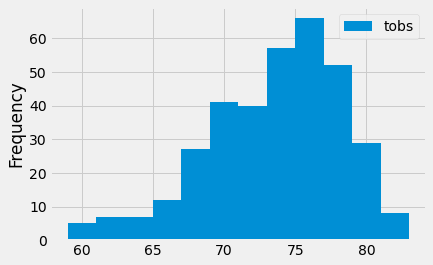

In [113]:
#and plot the results as a histogram
extremum_temp_df.plot.hist(bins=12)
plt.savefig(f"{title}.png")
plt.show()

## Bonus Challenge Assignment

In [98]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [103]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_results = calc_temps("2016-07-15","2016-07-25")
trip_results

[(71.0, 77.49230769230769, 82.0)]

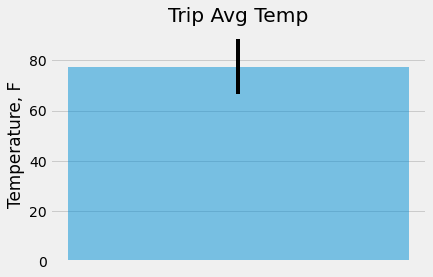

In [114]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots()
title = "Trip Avg Temp"
error = trip_results[0][2]-trip_results[0][0]
plt.bar(0,trip_results[0][1], yerr=error, alpha=0.5,)
plt.xticks([],[])
plt.title(title)
plt.ylabel('Temperature, F')
plt.savefig(f"{title}.png")
plt.show()

In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
